In [2]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
path_root = "D:\\UVG\\2022\\SECURITY DATA SCIENCE\\SDS-LAB7\\malimg_paper_dataset_imgs\\"

In [6]:
from keras.preprocessing.image import ImageDataGenerator

batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [7]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [9]:
# Usamos next() para recorrer todos los elementos y generar un batch de imagenes y label del data set
imgs, labels = next(batches)

In [10]:
# nuestras imagenes estan en RGB con formato 64x64 [width x length x depth].
imgs.shape

(9339, 64, 64, 3)

In [11]:
# Se hace plot a la muestra de imagenes con label 

def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

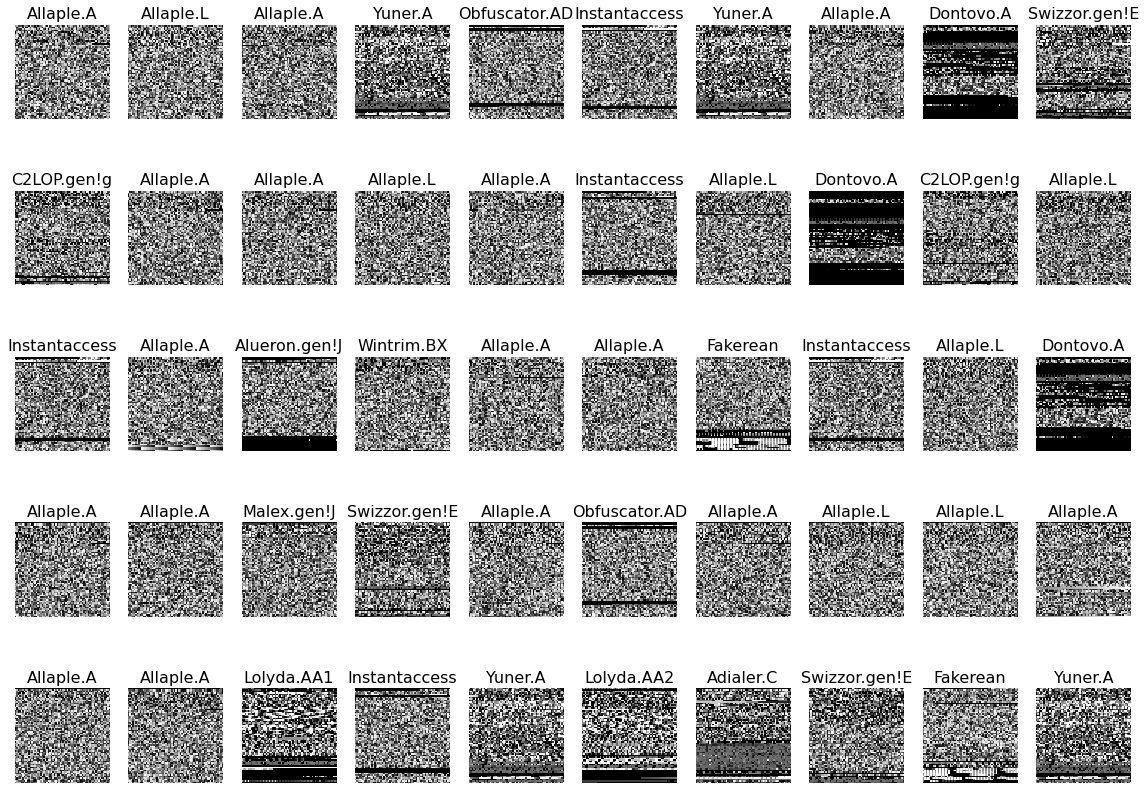

In [12]:
plots(imgs, titles = labels)

# Análisis

In [13]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

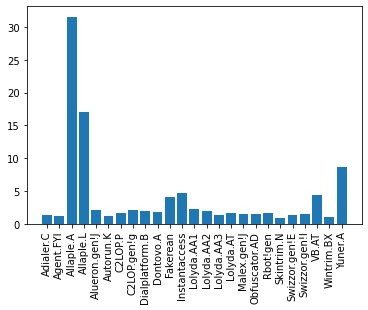

In [14]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
#Los datos estan desbalanceados: muchos son de clase 2 : Allaple.A y clase 3 : Allaple.L

# Entrenamiento y prueba
Se divide la data en 70% train y 30% test 

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [16]:
X_train.shape

(6537, 64, 64, 3)

In [17]:
X_test.shape

(2802, 64, 64, 3)

In [18]:
y_train.shape

(6537, 25)

In [19]:
y_test.shape

(2802, 25)

# Modelo de Red Neural Convolutional

In [21]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization

In [22]:
num_classes = 25

#construccion del modelo
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [23]:
Malware_model = malware_model()

In [24]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 30)        840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2940)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [25]:
y_train.shape

(6537, 25)

In [27]:
y_train_new = np.argmax(y_train, axis=1)
y_train_new

array([24,  2, 10, ...,  3,  8, 22], dtype=int64)

In [32]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_new),
                                                 y_train_new)

c:\users\camila\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], y=[24  2 10 ...  3  8 22] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [33]:
class_weights

array([2.90533333, 3.44052632, 0.12589312, 0.23325602, 1.92264706,
       3.39584416, 2.44373832, 1.81583333, 2.29368421, 2.39889908,
       0.98671698, 0.89547945, 1.67615385, 1.96601504, 2.90533333,
       2.25413793, 2.64121212, 2.6956701 , 2.58891089, 4.84222222,
       2.97136364, 2.97136364, 0.95430657, 3.78956522, 0.46361702])

In [34]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
205/205 [==============================] - 25s 118ms/step - loss: 1.5871 - accuracy: 0.5105 - val_loss: 0.8620 - val_accuracy: 0.7191
Epoch 2/10
205/205 [==============================] - 22s 109ms/step - loss: 0.7736 - accuracy: 0.7323 - val_loss: 0.4229 - val_accuracy: 0.8876
Epoch 3/10
205/205 [==============================] - 25s 121ms/step - loss: 0.5178 - accuracy: 0.8391 - val_loss: 0.3255 - val_accuracy: 0.9172
Epoch 4/10
205/205 [==============================] - 23s 110ms/step - loss: 0.3568 - accuracy: 0.8920 - val_loss: 0.2601 - val_accuracy: 0.9258
Epoch 5/10
205/205 [==============================] - 23s 111ms/step - loss: 0.2865 - accuracy: 0.9117 - val_loss: 0.2092 - val_accuracy: 0.9400
Epoch 6/10
205/205 [==============================] - 23s 112ms/step - loss: 0.2632 - accuracy: 0.9180 - val_loss: 0.1824 - val_accuracy: 0.9443
Epoch 7/10
205/205 [==============================] - 23s 114ms/step - loss: 0.2095 - accuracy: 0.9304 - val_loss: 0.1805 - val_ac

In [36]:
scores = Malware_model.evaluate(X_test, y_test)

88/88 [==============================] - 2s 28ms/step - loss: 0.1607 - accuracy: 0.9529


In [38]:
print('Accuracy final CNN: ', scores[1])
# Fue bastante alto el acc obtenido

Accuracy final CNN:  0.9528908133506775


# Matriz de confusión

In [58]:
import numpy as np
import pandas as pd

In [55]:
from keras.utils.np_utils import to_categorical
y_predict = np.argmax(Malware_model.predict(X_test), axis=-1)
y_predict

array([10, 24, 24, ...,  2, 24,  3], dtype=int64)

In [47]:
y_test2 = np.argmax(y_test, axis=1)
y_test2

array([10, 24, 24, ...,  2, 24,  3], dtype=int64)

In [56]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_predict)

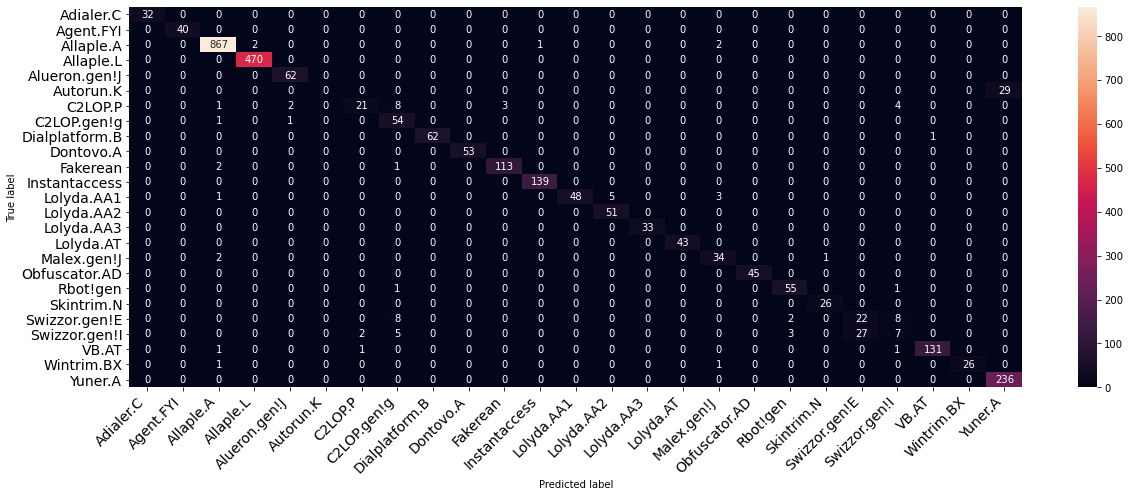

In [57]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

En general se clasificaron correctamente los malwares. Se identifico que el malware Swizzor.gen!E se confunde con Swizzor.gen!l y viceversa, posiblemente por pertenecer a la misma familia y tener así mayor similitud entre ellos. La mayoría de malware Autorun.K se confunde con Yuner.A y una razón de eso puede ser la pequeña muestra utilizada de este tipo de malware en el laboratorio